<a href="https://colab.research.google.com/github/cbuie/colab/blob/master/airbnb/models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modeling

### Load Dependencies

In [0]:
# Importing required libraries
import pandas as pd
import numpy as np
from numpy.random import seed
seed(123)
from IPython.core.display import HTML
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score, mean_absolute_error
import time
from keras import models, layers, optimizers, regularizers
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.rcParams.update({
    "lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "white",
    "axes.facecolor": "#383838",
    "axes.edgecolor": "lightgray",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "lightgray",
    "figure.facecolor": "#383838",
    "figure.edgecolor": "#383838",
    })
%matplotlib inline
%tensorflow_version 1.x

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
df = pd.read_csv('/content/drive/My Drive/data/processed_data/processed_dummy.csv',low_memory=False, index_col='id')

### Final Review

In [22]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84165 entries, 11551 to 39869282
Data columns (total 122 columns):
host_is_superhost                                  84165 non-null float64
host_listings_count                                84165 non-null float64
host_identity_verified                             84165 non-null float64
latitude                                           84165 non-null float64
longitude                                          84165 non-null float64
accommodates                                       84165 non-null int64
bathrooms                                          84165 non-null float64
bedrooms                                           84165 non-null float64
beds                                               84165 non-null float64
price                                              84165 non-null int64
security_deposit                                   84165 non-null int64
cleaning_fee                                       84165 non-null int64
gue

In [23]:
df.head()

,host_is_superhost,host_listings_count,host_identity_verified,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_90,number_of_reviews,number_of_reviews_ltm,instant_bookable,host_days_active,check_in_24h,air_conditioning,high_end_electronics,bbq,balcony,bed_linen,breakfast,tv,coffee_machine,cooking_basics,white_goods,elevator,child_friendly,parking,outdoor_space,host_greeting,internet,long_term_stays,pets_allowed,...,neighbourhood_cleansed_Waltham Forest,neighbourhood_cleansed_Wandsworth,neighbourhood_cleansed_Westminster,property_type_Apartment,property_type_House,property_type_Other,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,review_scores_rating_0-79/100,review_scores_rating_80-94/100,review_scores_rating_95-100/100,review_scores_rating_nan,review_scores_accuracy_0-8/10,review_scores_accuracy_10/10,review_scores_accuracy_9/10,review_scores_accuracy_nan,review_scores_cleanliness_0-8/10,review_scores_cleanliness_10/10,review_scores_cleanliness_9/10,review_scores_cleanliness_nan,review_scores_value_0-8/10,review_scores_value_10/10,review_scores_value_9/10,review_scores_value_nan,cancellation_policy_flexible,cancellation_policy_luxury_super_strict_95,cancellation_policy_moderate,cancellation_policy_strict_14_with_grace_period,time_since_first_review_0-6 months,time_since_first_review_1-2 years,time_since_first_review_2-3 years,time_since_first_review_4+ years,time_since_first_review_6-12 months,time_since_first_review_nan,time_since_last_review_1+ year,time_since_last_review_2-6 months,time_since_last_review_6-12 months,time_since_last_review_nan
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11551,1.0,3.0,1.0,51.46225,-0.11732,4,1.0,1.0,1.0,88,400,30,2,20,3,180,61,185,2,1,3797.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0
38151,0.0,1.0,0.0,51.41940,-0.08722,2,1.0,1.0,1.0,65,0,0,1,0,1,730,90,0,0,0,3516.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1
13913,0.0,4.0,0.0,51.56802,-0.11121,2,1.0,1.0,0.0,65,100,15,1,15,1,29,90,19,5,0,3753.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,...,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0
38407,0.0,1.0,0.0,51.49995,-0.02624,2,1.0,1.0,1.0,79,0,0,2,0,2,365,0,137,0,1,3515.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0
90700,0.0,2.0,0.0,51.51074,-0.19853,2,1.0,1.0,1.0,105,0,35,2,10,2,1125,24,339,33,1,3246.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0


### Collinearity Check

In [0]:
def multi_collinearity_heatmap(df, figsize=(11,9)):
    
    """
    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
    """
    
    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

In [0]:
# multi_collinearity_heatmap(df, figsize=(14,14))

In [0]:
# df.select_dtypes(include='number').hist(figsize=(20,20));

In [0]:
# # Dropping collinear features
# to_drop = ['beds',
#            'bedrooms',
#            'guests_included', 
#            'host_response_rate_unknown',
#            'host_response_rate_0-49%',
#            'property_type_Apartment',
#            'room_type_Private room']
# to_drop.extend(list(transformed_df.columns[transformed_df.columns.str.endswith('nan')]))

# transformed_df.drop(to_drop, axis=1, inplace=True)

In [28]:
df.describe()

,host_is_superhost,host_listings_count,host_identity_verified,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_90,number_of_reviews,number_of_reviews_ltm,instant_bookable,host_days_active,check_in_24h,air_conditioning,high_end_electronics,bbq,balcony,bed_linen,breakfast,tv,coffee_machine,cooking_basics,white_goods,elevator,child_friendly,parking,outdoor_space,host_greeting,internet,long_term_stays,pets_allowed,...,neighbourhood_cleansed_Waltham Forest,neighbourhood_cleansed_Wandsworth,neighbourhood_cleansed_Westminster,property_type_Apartment,property_type_House,property_type_Other,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,review_scores_rating_0-79/100,review_scores_rating_80-94/100,review_scores_rating_95-100/100,review_scores_rating_nan,review_scores_accuracy_0-8/10,review_scores_accuracy_10/10,review_scores_accuracy_9/10,review_scores_accuracy_nan,review_scores_cleanliness_0-8/10,review_scores_cleanliness_10/10,review_scores_cleanliness_9/10,review_scores_cleanliness_nan,review_scores_value_0-8/10,review_scores_value_10/10,review_scores_value_9/10,review_scores_value_nan,cancellation_policy_flexible,cancellation_policy_luxury_super_strict_95,cancellation_policy_moderate,cancellation_policy_strict_14_with_grace_period,time_since_first_review_0-6 months,time_since_first_review_1-2 years,time_since_first_review_2-3 years,time_since_first_review_4+ years,time_since_first_review_6-12 months,time_since_first_review_nan,time_since_last_review_1+ year,time_since_last_review_2-6 months,time_since_last_review_6-12 months,time_since_last_review_nan
count,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,8.416500e+04,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,...,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000
mean,0.149504,27.283538,0.357702,51.509825,-0.128150,3.189426,1.298313,1.404836,1.741128,113.491368,111.960874,32.215767,1.614923,7.417264,4.042904,1.391633e+04,33.058932,17.561611,6.733512,0.434112,1562.377128,0.064385,0.057530,0.013830,0.031557,0.121428,0.357797,0.131658,0.690180,0.188962,0.321701,0.866382,0.224785,0.304046,0.397671,0.118981,0.186930,0.964189,0.218678,0.108976,...,0.016943,0.050342,0.111626,0.688528,0.248904,0.062568,0.554660,0.013129,0.424785,0.007426,0.083515,0.286639,0.377069,0.252777,0.069494,0.507028,0.170071,0.253407,0.121286,0.413272,0.212202,0.253241,0.104081,0.374811,0.267142,0.253965,0.322212,0.000036,0.236274,0.441478,0.074520,0.193394,0.241169,0.113432,0.143682,0.233803,0.214068,0.389806,0.162324,0.233803
std,0.356587,143.486332,0.479327,0.046416,0.093189,2.003683,0.595725,0.902177,1.255555,114.311591,185.784608,42.283474,1.338131,13.820571,15.598156,3.464302e+06,33.668907,36.921518,12.801745,0.495643,800.268335,0.245440,0.232854,0.116786,0.174819,0.326626,0.479355,0.338121,0.462422,0.391481,0.467132,0.340244,0.417443,0.460005,0.489420,0.323768,0.389858,0.185819,0.413352,0.311611,...,0.129058,0.218650,0.314908,0.463098,0.432381,0.242185,0.497006,0.113828,0.494313,0.085

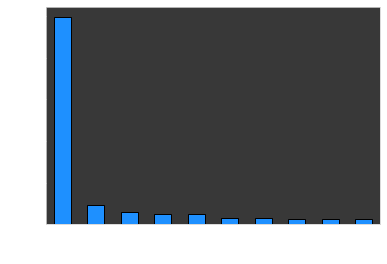

In [29]:
df.maximum_nights.value_counts(ascending=False)[:10].plot(kind='bar',color='dodgerblue', edgecolor='k');
# df.drop(['minimum_nights','maximum_nights'], axis=1,inplace=True)

In [0]:
numerical_columns = ['accommodates', 'availability_90', 'bathrooms', 'cleaning_fee', 'extra_people', 'host_days_active', 'host_listings_count', 'maximum_nights', 'minimum_nights', 'number_of_reviews', 'price', 'security_deposit']

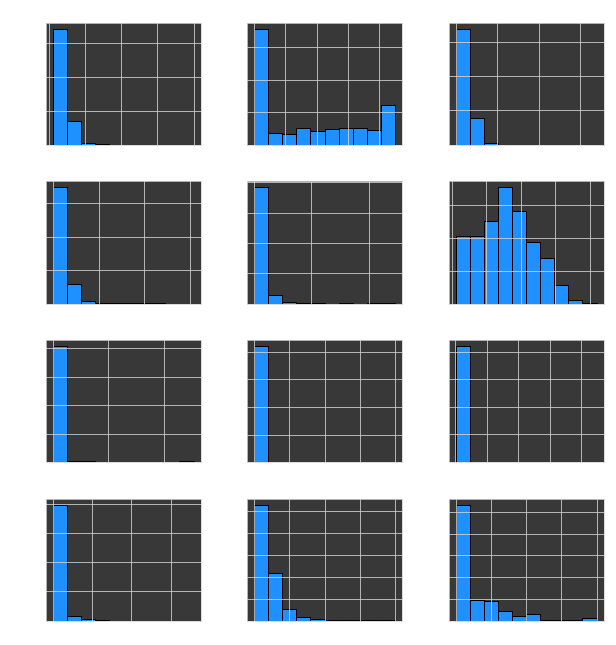

In [31]:
df[numerical_columns].hist(figsize=(10,11),color='dodgerblue', edgecolor='k');

In [0]:
# df.drop(['host_listings_count', 'maximum_nights','minimum_nights'],axis=1,inplace=True)

### Transform

In [0]:
# Log transforming columns
numerical_columns = [i for i in numerical_columns if i not in ['availability_90', 'price','host_days_active']] # Removing items not to be transformed

for col in numerical_columns:
    df[col] = df[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01
    df[col] = np.log(df[col])

In [0]:
# Separating X and y
df=df.dropna()

X = df.drop('price', axis=1)
y = df.price

# Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

## Split Data Train/Test

In [35]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

HTML('<h2>Response Variavble test set: <font color="red">{0}</font> <br> Response Variavble train set: <font color="red">{1}</font></h2>'.format(len(y_test),len(y_train)))

## Multivariate Regression

In [0]:
import statsmodels.api as sm

y = y_train.values
X = X_train
MVR = sm.OLS(y, X).fit()
predictions = MVR.predict(X_test) # make the predictions by the model


### Review Regression Summary

In [44]:
# Print out the statistics
MVR.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.240
Model:                            OLS   Adj. R-squared (uncentered):              0.239
Method:                 Least Squares   F-statistic:                              198.7
Date:                Tue, 25 Feb 2020   Prob (F-statistic):                        0.00
Time:                        23:35:52   Log-Likelihood:                     -4.2795e+05
No. Observations:               67332   AIC:                                  8.561e+05
Df Residuals:                   67225   BIC:                                  8.571e+05
Df Model:                         107                                                  
Covariance Type:            nonrobust                                                  
===================================================================================================================
                                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
host_is_superhost                                   1.5249      0.647      2.355      0.019       0.256       2.794
host_listings_count                                 4.5418      0.688      6.600      0.000       3.193       5.891
host_identity_verified                             -1.9811      0.597     -3.319      0.001      -3.151      -0.811
latitude                                           -3.7529      1.725     -2.176      0.030      -7.133      -0.373
longitude                                          11.1096      2.125      5.227      0.000       6.944      15.275
accommodates                                       10.7773      1.021     10.553      0.000       8.776      12.779
bathrooms                                           8.2860      0.613     13.515      0.000       7.084       9.488
bedrooms                                           28.6367      0.925     30.945      0.000      26.823      30.450
beds                                                2.4645      0.910      2.707      0.007       0.680       4.249
security_deposit                                    6.3288      0.648      9.765      0.000       5.059       7.599
cleaning_fee                                       -6.3024      0.686     -9.186      0.000      -7.647      -4.958
guests_included                                     6.0642      0.676      8.977      0.000       4.740       7.388
extra_people                                       -5.1701      0.621     -8.327      0.000      -6.387      -3.953
minimum_nights                                     -0.8964      0.583     -1.537      0.124      -2.039       0.246
maximum_nights                                      2.4153      0.571      4.230      0.000       1.296       3.535
availability_90                                    13.6604      0.640     21.343      0.000      12.406      14.915
number_of_reviews                                 -11.6660      2.710     -4.305      0.000     -16.978      -6.354
number_of_reviews_ltm                              -1.6526      0.834     -1.983      0.047      -3.286      -0.019
instant_bookable                                    2.0206      0.605      3.342      0.001       0.836       3.206
host_days_active                                   -3.1160      0.652     -4.778      0.000      -4.394      -1.838
check_in_24h                                       -0.6048      0.568     -1.065      0.287      -1.718       0.509
air_conditioning                                   10.3698      0.561     18.481      0.000       9.270      11.470
high_end_electronics                                0.5795      0.551      1.051    

In [0]:
MVR.params

## XGB Regressor

### Build Baseline XGB_R

In [36]:
xgb_reg_start = time.time()



xgb_reg = xgb.XGBRegressor(n_jobs=-1,
                           max_depth=10,
                           learning_rate=0.08,
                           n_estimators=150,
                           silent=False,
                           eta=0.03,
                           subsample=0.8,
                           objective='reg:squarederror')
xgb_reg.fit(X_train, y_train,verbose=True)
training_preds_xgb_reg = xgb_reg.predict(X_train)
test_preds_xgb_reg = xgb_reg.predict(X_test)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Test MSE:", round(mean_squared_error(y_test, test_preds_xgb_reg),4))
print("\nTraining MAE:", round(mean_absolute_error(y_train, training_preds_xgb_reg),4))
print("Test MAE:", round(mean_absolute_error(y_test, test_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Test r2:", round(r2_score(y_test, test_preds_xgb_reg),4))

Time taken to run: 0.8 minutes

Training MSE: 768.3566
Test MSE: 3786.2979

Training MAE: 17.1243
Test MAE: 29.8267

Training r2: 0.9399
Test r2: 0.7332


#### XGB Reg Train Psuedo Residuals

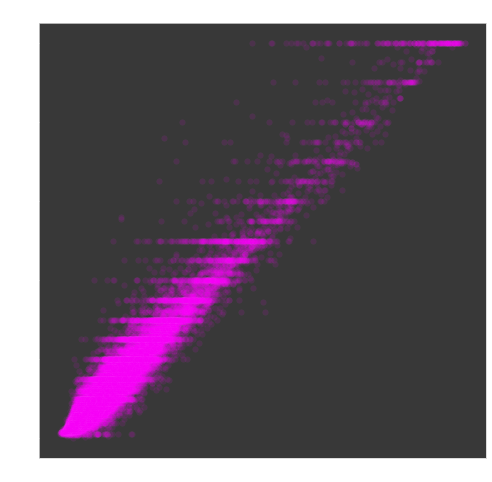

In [37]:
plt.figure(figsize=(8,8))
plt.title("Train Predicted vs Actual")
plt.scatter(training_preds_xgb_reg, y_train ,s=35,alpha=0.1,color='#FF00FF',edgecolors='white',linewidths=0.1);

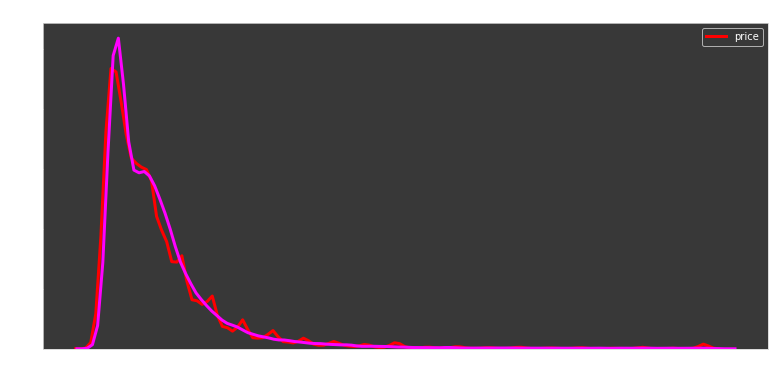

In [38]:
plt.figure(figsize=(13,6))
plt.title('Train Actual vs Predicted')
plt.xlabel('$ Price')
sns.kdeplot(y_train,c='red', linewidth=3);
sns.kdeplot(training_preds_xgb_reg, c='#FF00FF', linewidth=3)

In [39]:
pd.DataFrame([ y_train.values, training_preds_xgb_reg,y_train.values-training_preds_xgb_reg]).T.sample(20)

,0,1,2
50379,1000.0,865.121521,134.878479
61113,99.0,118.045433,-19.045433
62956,50.0,49.497810,0.502190
67299,100.0,101.700180,-1.700180
13117,126.0,155.865982,-29.865982
42672,63.0,67.751099,-4.751099
28331,129.0,144.070084,-15.070084
6845,403.0,370.585846,32.414154
20440,300.0,288.338379,11.661621
51427,190.0,179.840515,10.159485


#### XGB Reg Test Psuedo Residuals




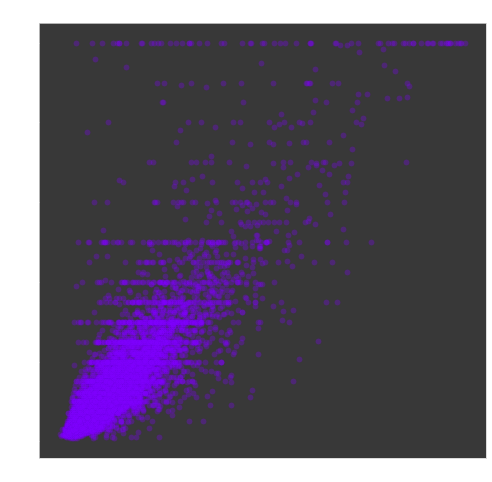

In [40]:
plt.figure(figsize=(8,8))
plt.title("Test Predicted vs Actual")
plt.scatter(test_preds_xgb_reg, y_test,s=35,alpha=0.3,color='#8000ff',edgecolors='k',linewidths=0.03);


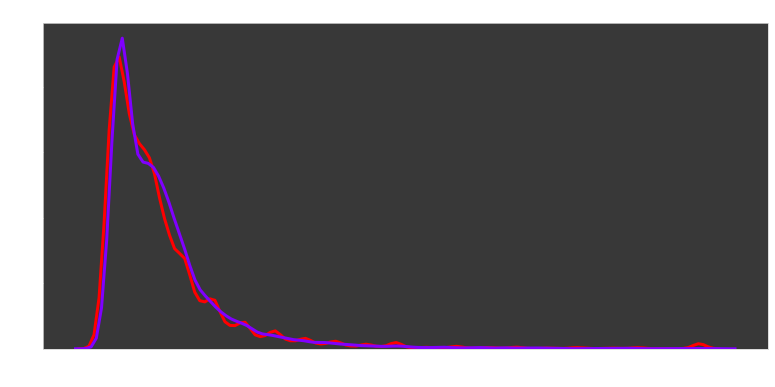

In [41]:
plt.figure(figsize=(13,6))
plt.title('Train Actual vs Predicted')
plt.xlabel('$ Price')
sns.kdeplot(y_test.values,c='red', linewidth=3)
sns.kdeplot(test_preds_xgb_reg, c='#8000ff', linewidth=3)

In [42]:
pd.DataFrame([ y_test.values, test_preds_xgb_reg,y_test.values-test_preds_xgb_reg, (((y_test.values/test_preds_xgb_reg)-1))]).T.sample(20)

,0,1,2,3
12100,220.0,210.560791,9.439209,0.044829
10645,250.0,159.070953,90.929047,0.571626
9059,35.0,31.005308,3.994692,0.128839
11248,50.0,65.091606,-15.091606,-0.231852
6467,36.0,29.170671,6.829329,0.234116
112,68.0,67.006874,0.993126,0.014821
16470,65.0,75.560684,-10.560684,-0.139764
5421,120.0,69.999153,50.000847,0.714306
674,69.0,64.020416,4.979584,0.077781
6896,90.0,82.555473,7.444527,0.090176


### Tune Parameters

In [0]:
# Parameters that we are going to tune.
params = {
    'max_depth':8,
    'learning_rate':0.1,
    'n_estimators':100,
    'eta':.3,
    'subsample': 0.8,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:squarederror',
    'eval_metric': "mae"
}

num_boost_round = 1000

In [0]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [0]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Test-mae:107.743
Will train until Test-mae hasn't improved in 10 rounds.
[1]	Test-mae:102.46
[2]	Test-mae:97.4406


### N Fold Cross-Validate

In [0]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'mae'},
    early_stopping_rounds=10
)
cv_results

,train-mae-mean,train-mae-std,test-mae-mean,test-mae-std
0,107.244005,0.176967,107.254900,0.754527
1,101.930268,0.172820,101.953415,0.742637
2,96.889241,0.164694,96.919427,0.737805


In [0]:
cv_results['test-mae-mean'].min()

30.053867599999997

### Parameter Tuning with 5 Fold Cross-Validation

In [0]:
# gridsearch_params = [
#     (max_depth, min_child_weight)
#     for max_depth in range(9,20)
#     for min_child_weight in range(1,)
# ]

gridsearch_params = [
    (max_depth)
    for max_depth in range(3,210)
]

# Define initial best params and MAE
min_mae = float("Inf")
best_params = None
for max_depth in gridsearch_params:
    print("CV with max_depth={}".format(
                             max_depth
                             ))
    # Update parameters
    params['max_depth'] = max_depth
    # params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=2,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best MAE
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth)
print("Best params: {},  MAE: {}".format(best_params, min_mae))

CV with max_depth=3
	MAE 32.933571 for 710 rounds
CV with max_depth=4
	MAE 32.1732425 for 439 rounds
CV with max_depth=5
	MAE 31.115467000000002 for 573 rounds
CV with max_depth=6
	MAE 30.7644815 for 380 rounds
CV with max_depth=7
	MAE 30.772370000000002 for 236 rounds
CV with max_depth=8
	MAE 30.528756 for 255 rounds
CV with max_depth=9
	MAE 30.4327575 for 225 rounds
CV with max_depth=10
	MAE 30.6706165 for 156 rounds
CV with max_depth=11


KeyboardInterrupt: ignored

## Random Forest Regressor

In [0]:
from sklearn.ensemble import RandomForestRegressor


In [0]:
regr = RandomForestRegressor(max_depth=9, verbose=True ,n_estimators = 110, random_state=123,criterion='mse',n_jobs=-1,)
regr.fit(X_train, y_train)
print(regr.feature_importances_)

# print(regr.predict([[0, 0, 0, 0]]))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.7s


[1.70100640e-02 2.38595995e-04 6.25549774e-02 3.56446508e-04
 1.35153306e-02 2.16504919e-02 1.93663658e-02 8.10277216e-02
 3.08500349e-01 2.50141406e-03 2.84694183e-02 1.06454000e-01
 6.20117275e-03 7.79262037e-03 9.04654590e-03 6.04655266e-03
 2.88243784e-02 5.56538882e-03 2.67265067e-03 7.69465152e-04
 3.84883463e-02 9.35749552e-04 1.98755608e-02 3.84874713e-05
 1.26166680e-04 3.66667217e-04 4.13712653e-04 8.71039483e-04
 8.72333838e-04 6.12300765e-04 3.05412208e-04 1.08095295e-03
 1.07281532e-03 4.22530416e-04 6.44149644e-04 2.96043253e-04
 2.58372488e-04 6.81554618e-04 2.86278189e-03 2.89033673e-04
 9.54141936e-04 5.86810123e-04 2.39182364e-04 1.33846943e-02
 3.38245426e-04 9.46541513e-04 1.50856176e-03 9.30023283e-05
 9.45534242e-04 6.60666222e-04 3.30249116e-03 1.62002730e-02
 4.20922897e-05 2.67951092e-05 8.42990100e-06 1.43031360e-04
 3.40966275e-05 2.47969558e-03 7.97321589e-04 6.06169682e-05
 7.48155953e-05 2.20659605e-06 3.72211879e-04 4.21520864e-04
 3.60238103e-04 1.065217

[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:   29.3s finished


In [0]:
pred = regr.predict(X_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 110 out of 110 | elapsed:    0.1s finished


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 110 out of 110 | elapsed:    0.2s finished


0.6031251916904914


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 110 out of 110 | elapsed:    0.3s finished


0.7077618012829814


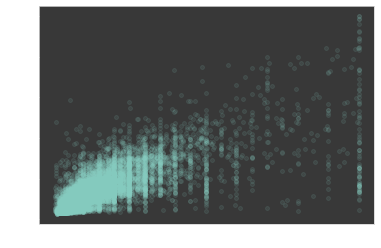

In [0]:
plt.scatter(y_test,pred,s=16,alpha=0.1)
print(regr.score(X_test,y_test))
print(regr.score(X_train,y_train))

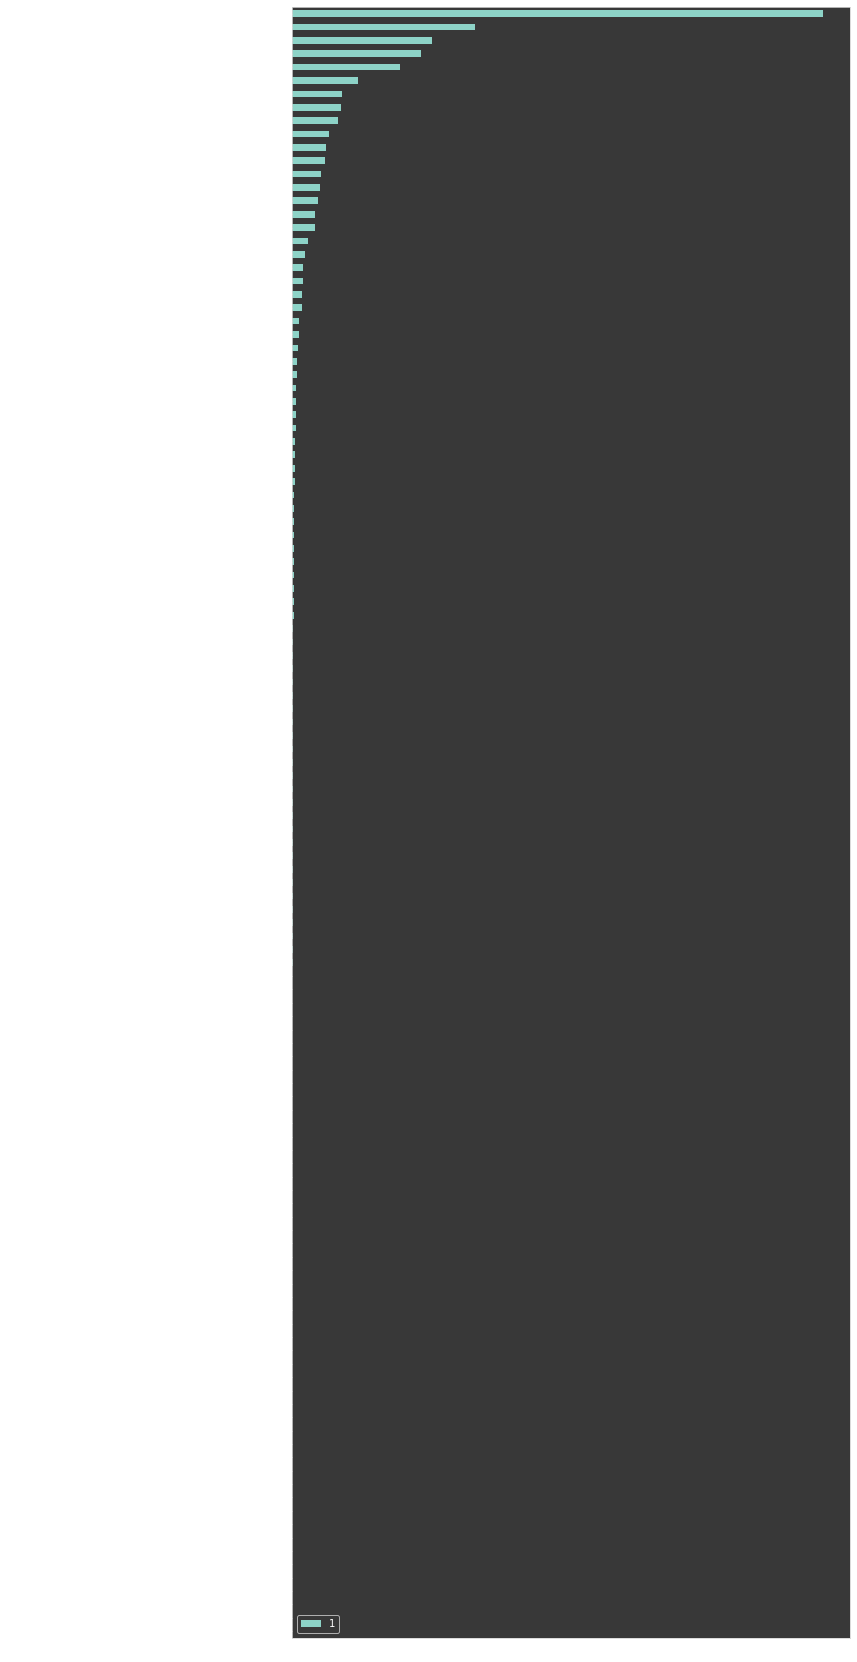

In [0]:
pd.DataFrame([X.columns,regr.feature_importances_]).T.sort_values(by=1,ascending=True).set_index(0).plot(kind='barh', figsize=(10,30));

## 3 Layer ADAM NN

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 128)               15616     
_________________________________________________________________
dense_10 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_11 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 257       
Total params: 114,689
Trainable params: 114,689
Non-trainable params: 0
_________________________________________________________________
None


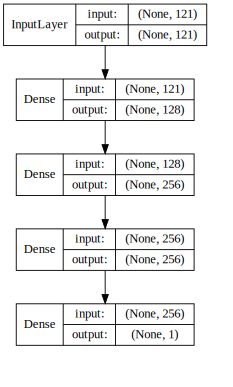

In [0]:
# Building the model
nn2 = models.Sequential()
nn2.add(layers.Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
nn2.add(layers.Dense(256, activation='relu'))
nn2.add(layers.Dense(256, activation='relu'))
nn2.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn2.compile(loss='mean_absolute_error',
            optimizer='adam',
            metrics=['mean_absolute_error'])

# Model summary
print(nn2.summary())

# Visualising the neural network
SVG(model_to_dot(nn2, show_layer_names=False, show_shapes=True, dpi=65).create(prog='dot', format='svg'))

In [0]:
# Training the model
nn2_start = time.time()

nn2_history = nn2.fit(X_train,
                  y_train,
                  epochs=100,
                  batch_size=256,
                  validation_split = 0.10)

nn2_end = time.time()

print(f"Time taken to run: {round((nn2_end - nn2_start)/60,1)} minutes")




Train on 60598 samples, validate on 6734 samples
Epoch 1/100





60598/60598 [==============================] - 2s 37us/step - loss: 43.7481 - mean_absolute_error: 43.7481 - val_loss: 35.2087 - val_mean_absolute_error: 35.2087
Epoch 2/100
60598/60598 [==============================] - 1s 24us/step - loss: 34.8519 - mean_absolute_error: 34.8519 - val_loss: 34.5161 - val_mean_absolute_error: 34.5161
Epoch 3/100
60598/60598 [==============================] - 1s 24us/step - loss: 33.9071 - mean_absolute_error: 33.9071 - val_loss: 33.6494 - val_mean_absolute_error: 33.6494
Epoch 4/100
60598/60598 [==============================] - 1s 25us/step - loss: 33.0527 - mean_absolute_error: 33.0527 - val_loss: 33.0495 - val_mean_absolute_error: 33.0495
Epoch 5/100
60598/60598 [==============================] - 1s 24us/step - loss: 32.2879 - mean_absolute_error: 32.2879 - val_loss: 32.6196 - val_mean_absolute_error: 32.6196
Epoch 6/100
60598/60598 [==============================] - 2s 25us/step -

In [0]:
def nn_model_evaluation(model, skip_epochs=0, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    """
    For a given neural network model that has already been fit, prints for the train and tests sets the MSE and r squared
    values, a line graph of the loss in each epoch, and a scatterplot of predicted vs. actual values with a line
    representing where predicted = actual values. Optionally, a value for skip_epoch can be provided, which skips that
    number of epochs in the line graph of losses (useful in cases where the loss in the first epoch is orders of magnitude
    larger than subsequent epochs). Training and test sets can also optionally be specified.
    """

    # MSE and r squared values
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    print("Training MAE:", round(mean_absolute_error(y_train, y_train_pred),4))
    print("Validation MAE:", round(mean_absolute_error(y_test, y_test_pred),4))
    print("\nTraining r2:", round(r2_score(y_train, y_train_pred),4))
    print("Validation r2:", round(r2_score(y_test, y_test_pred),4))
    
    # Line graph of losses
    model_results = model.history.history
    plt.plot(list(range((skip_epochs+1),len(model_results['loss'])+1)), model_results['loss'][skip_epochs:], label='Train')
    plt.plot(list(range((skip_epochs+1),len(model_results['val_loss'])+1)), model_results['val_loss'][skip_epochs:], label='Test', color='green')
    plt.legend()
    plt.title('Training and test loss at each epoch', fontsize=14)
    plt.show()
    
    # Scatterplot of predicted vs. actual values
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle('Predicted vs. actual values', fontsize=14, y=1)
    plt.subplots_adjust(top=0.93, wspace=0)
    
    ax1.scatter(y_test, y_test_pred, s=2, alpha=0.7)
    ax1.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
    ax1.set_title('Test set')
    ax1.set_xlabel('Actual values')
    ax1.set_ylabel('Predicted values')
    
    ax2.scatter(y_train, y_train_pred, s=2, alpha=0.7)
    ax2.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
    ax2.set_title('Train set')
    ax2.set_xlabel('Actual values')
    ax2.set_ylabel('')
    ax2.set_yticklabels(labels='')
    
    plt.show()

Training MAE: 16.1288
Validation MAE: 36.5911

Training r2: 0.869
Validation r2: -1.1024


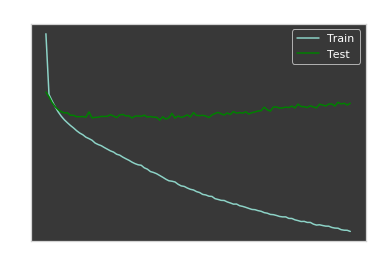

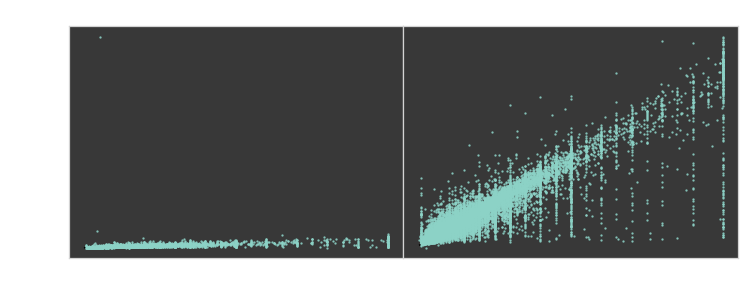

In [0]:
nn_model_evaluation(nn2)

## 3 Layer NN with Dropout Regularization

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_13 (Dropout)         (None, 121)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 128)               15616     
_________________________________________________________________
dropout_14 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_16 (Dropout)         (None, 512)              

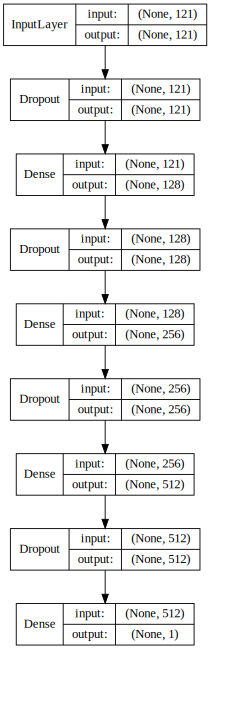

In [0]:
# Building the model
NND = models.Sequential()
NND.add(layers.Dropout(0.5, input_shape=(X_train.shape[1],)))
NND.add(layers.Dense(128, activation='relu'))
NND.add(layers.Dropout(0.5))
NND.add(layers.Dense(256, activation='relu'))
NND.add(layers.Dropout(0.5))
NND.add(layers.Dense(512, activation='relu'))
NND.add(layers.Dropout(0.5))
NND.add(layers.Dense(1, activation='linear'))

# Compiling the model
NND.compile(loss='mean_absolute_error',
            optimizer='adam',
            metrics=['mean_absolute_error'])

# Model summary
print(NND.summary())

# Visualising the neural network
SVG(model_to_dot(NND, show_layer_names=False, show_shapes=True,dpi=65).create(prog='dot', format='svg'))
# SVG(model_to_dot(nn4, show_layer_names=False, show_shapes=True, dpi=65).create(prog='dot', format='svg'))

In [0]:
# Training the model
NND_start = time.time()

NND_history = nn5.fit(X_train,
                  y_train,
                  epochs=50,
                  batch_size=256,
                  validation_split = 0.1)

NND_end = time.time()

print(f"Time taken to run: {round((NND_end - NND_start)/60,1)} minutes")

Train on 60598 samples, validate on 6734 samples
Epoch 1/50
60598/60598 [==============================] - 4s 64us/step - loss: 52.8754 - mean_absolute_error: 52.8754 - val_loss: 45.2150 - val_mean_absolute_error: 45.2150
Epoch 2/50
60598/60598 [==============================] - 3s 50us/step - loss: 46.2130 - mean_absolute_error: 46.2130 - val_loss: 47.3470 - val_mean_absolute_error: 47.3470
Epoch 3/50
50944/60598 [========================>.....] - ETA: 0s - loss: 45.4740 - mean_absolute_error: 45.4740

KeyboardInterrupt: ignored

Training MSE: 9147.2914
Validation MSE: 10697.9227

Training r2: 0.2845
Validation r2: 0.2463


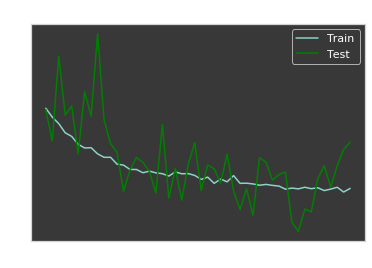

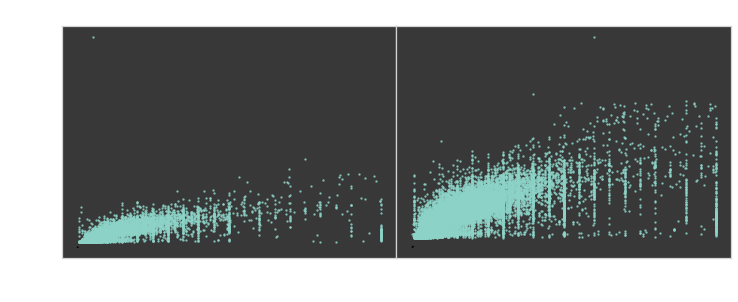

In [0]:
nn_model_evaluation(NND, skip_epochs=2)